# Handling time convention in CMIP6 models

## Adjusting time conventions of branched runs
The `historical` and scenario runs for CMIP6 are usually 'branched' from a long control run (usually `experiment_id='piControl'`). This control run is then continued to evaluate and enable the removal of drift in the simulation. To easily remove the drift, the timing  of the runs has to be aligned. Some output in the CMIP6 DECK already follows that convention, whereas some modelling centers opt to keep the time convention for the control run in sequential years since the start. To illustrate this we will pick some data from `MIROC-ES2L` and `GFDL-CM4`.

In [ ]:
from dask.distributed import Client

client = Client("tcp://10.32.2.194:44371")
client

In [326]:
%load_ext autoreload
%autoreload 2
import intake
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import matplotlib.pyplot as plt
import cftime

col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")
models = ['MIROC-ES2L', 'GFDL-CM4']
experiments = ['historical', 'piControl']
cat = col.search(variable_id='sos',table_id='Omon', grid_label='gn', experiment_id = experiments, source_id = models, member_id=['r1i1p1f1','r1i1p1f2'])
data_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times':False},preprocess=combined_preprocessing)
# need to reprocess to get consistent cf_time values
data_dict = {k:xr.decode_cf(ds, use_cftime=True) for k, ds in data_dict.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 4 group(s)


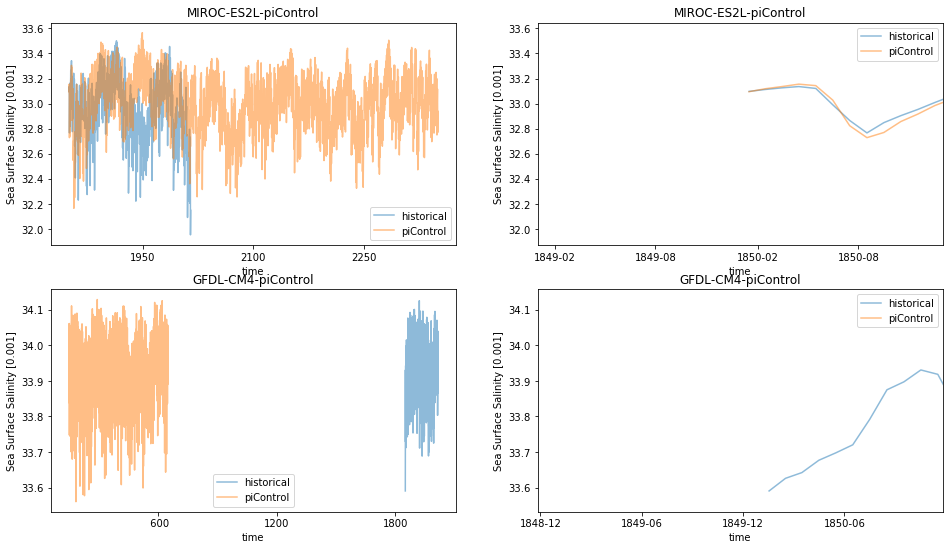

In [327]:
fig, axarr = plt.subplots(ncols=2, nrows=len(models), figsize=[16,9])
in_dict = data_dict
for mi,model in enumerate(models):
    for experiment in experiments:
        ax = axarr[mi,0]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        if experiment == 'historical':
            branch_year = ds.time.data[0].year
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_title(f"{model}-{experiment}")
    ax.legend()
    # zoom in on the branch point
    for experiment in experiments:
        ax = axarr[mi,1]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_xlim([cftime.DatetimeGregorian(branch_year-1, 1, 1), cftime.DatetimeGregorian(branch_year+1, 1, 1)])
    ax.set_title(f"{model}-{experiment}")
    ax.legend()

As you can see the GDFL model uses a different convention for the historical run ('real years') and the piControl run (years since 0).
We can infer the branch point using the metadata of the dataset:


In [328]:
{k:v for k,v in data_dict['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn'].attrs.items() if ('branch' in k) | ('parent' in k)}

{'branch_method': 'standard',
 'branch_time_in_child': 0.0,
 'branch_time_in_parent': 36500.0,
 'parent_activity_id': 'CMIP',
 'parent_experiment_id': 'piControl',
 'parent_mip_era': 'CMIP6',
 'parent_source_id': 'GFDL-CM4',
 'parent_time_units': 'days since 0001-1-1',
 'parent_variant_label': 'r1i1p1f1'}

`cmip6_preprocessing` reads this data and automatically shifts the time convention to the child run for a full dictionary with `unify_branched_time`.
You only have to pass the input `data_dict` and define the branching order. E.g. here the `historical` was branched of the `piControl`. All `piControl` runs will be shifted to the same time convention as the `historical`.

In [329]:
from cmip6_preprocessing.time_utils import unify_branched_time
data_dict_timefixed = unify_branched_time(data_dict, experiment_id_order=['historical', 'piControl'])

You could add another run in that order, by e.g. passing `experiment_id_order=['spp..','historical', 'piControl']`. This would recursively adjust the time convention of the `historical` to the `spp...` run and then adjust the `piControl` to that same convention as well. Just make sure that the values are ordered from child to parent.

For instance, this doesnt work, because `piControl` is not a child of `historical`

In [330]:
unify_branched_time(data_dict, experiment_id_order=['piControl', 'historical'])

ValueError: Source(GFDL-CM4) not consistent with Target(GFDL-CM4) [source experiment_id: historical | target parent_experiment_id: piControl-spinup]. 

Now lets plot the unified results:

KeyError: 'CMIP.MIROC.MIROC-ES2L.historical.Omon.gn'

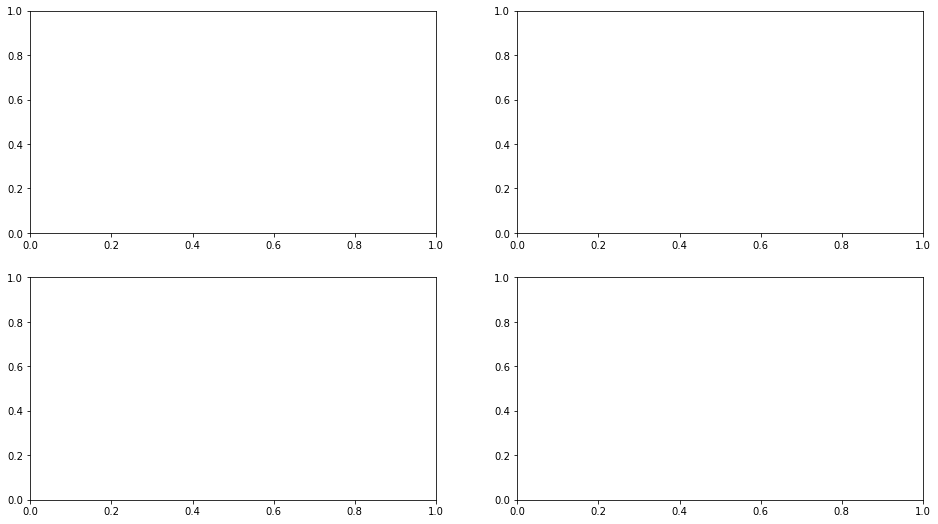

In [331]:
fig, axarr = plt.subplots(ncols=2, nrows=len(models), figsize=[16,9])
in_dict = data_dict_timefixed
for mi,model in enumerate(models):
    for experiment in experiments:
        ax = axarr[mi,0]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        if experiment == 'historical':
            branch_year = ds.time.data[0].year
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_title(f"{model}-{experiment}")
    ax.legend()
    # zoom in on the branch point
    for experiment in experiments:
        ax = axarr[mi,1]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_xlim([cftime.DatetimeGregorian(branch_year-1, 1, 1), cftime.DatetimeGregorian(branch_year+1, 1, 1)])
    ax.set_title(f"{model}-{experiment}")
    ax.legend()

We can see that the `MIROC-ES2L` runs were not affected, since they were already provided in a matching time convention. The `GFDL-CM4` data is now aligned as well and ready for e.g. removing a drift.

![smooth](https://media.giphy.com/media/vMnuZGHJfFSTe/giphy.gif)

# Devise a test for this.

In [292]:
# get all models with historical and piControl run

In [316]:
# modified search to check for models with all three (picontrol, historical, 'spss585')
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")
experiment_ids = ['historical', 'piControl'] #  seems to have the most so far 'ssp119' 'ssp370',,'ssp126' 'spss585' # there are
table_ids = ['Omon'] # , 'Oyr'for the other models the yearly data would give more results but for this combo not
# Note that the yearly files do not have the necessary metadata to shift the control run time!!!

query = dict(experiment_id=experiment_ids, table_id=table_ids, variable_id=['tos'])

cat = col.search(**query)
cat.df = cat.df.drop_duplicates(subset=['source_id', 'experiment_id'])

# pick only the ones that have both experiments
models = cat.df['source_id'].unique()
full_models = [] # models that have both experiments available
for model in models:
    df_model = cat.df[cat.df['source_id']==model]
    if set(df_model['experiment_id']) == set(experiment_ids):
        full_models.append(model)
cat.df = cat.df[[(m in full_models) for m in cat.df['source_id'].values]]

data_dict_raw = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times':False})

# need to reprocess to get consistent cf_time values
data_dict = {k:xr.decode_cf(ds, use_cftime=True) for k, ds in data_dict_raw.items()}

Progress: |███████------------------------------------------------------------------------| 9.1% 

Progress: |██████████---------------------------------------------------------------------| 12.1% 

Progress: |███████████--------------------------------------------------------------------| 13.6% 

Progress: |████████████-------------------------------------------------------------------| 15.2% 

Progress: |█████████████------------------------------------------------------------------| 16.7% 

Progress: |██████████████-----------------------------------------------------------------| 18.2% 

Progress: |█████████████████--------------------------------------------------------------| 21.2% 

Progress: |██████████████████-------------------------------------------------------------| 22.7% 

Progress: |███████████████████------------------------------------------------------------| 24.2% 

Progress: |██████████████████████---------------------------------------------------------| 27.3% 

Progress: |███████████████████████--------------------------------------------------------| 28.8% 

Progress: |████████████████████████-------------------------------------------------------| 30.3% 

Progress: |█████████████████████████------------------------------------------------------| 31.8% 

Progress: |██████████████████████████-----------------------------------------------------| 33.3% 

Progress: |█████████████████████████████--------------------------------------------------| 36.4% 

Progress: |██████████████████████████████-------------------------------------------------| 37.9% 

Progress: |████████████████████████████████-----------------------------------------------| 40.9% 

Progress: |████████████████████████████████████-------------------------------------------| 45.5% 

Progress: |█████████████████████████████████████------------------------------------------| 47.0% 

Progress: |██████████████████████████████████████-----------------------------------------| 48.5% 

Progress: |████████████████████████████████████████---------------------------------------| 50.0% 

Progress: |██████████████████████████████████████████-------------------------------------| 53.0% 

Progress: |████████████████████████████████████████████-----------------------------------| 56.1% 

Progress: |█████████████████████████████████████████████----------------------------------| 57.6% 

Progress: |███████████████████████████████████████████████--------------------------------| 59.1% 

Progress: |████████████████████████████████████████████████-------------------------------| 60.6% 

Progress: |██████████████████████████████████████████████████-----------------------------| 63.6% 

Progress: |███████████████████████████████████████████████████----------------------------| 65.2% 

Progress: |██████████████████████████████████████████████████████████████████-------------| 83.3% 

Progress: |████████████████████████████████████████████████████████████████████-----------| 86.4% 

Progress: |███████████████████████████████████████████████████████████████████████--------| 89.4% 

Progress: |████████████████████████████████████████████████████████████████████████-------| 90.9% 

Progress: |█████████████████████████████████████████████████████████████████████████------| 92.4% 

Progress: |███████████████████████████████████████████████████████████████████████████----| 95.5% 

Progress: |█████████████████████████████████████████████████████████████████████████████--| 97.0% 

Progress: |██████████████████████████████████████████████████████████████████████████████-| 98.5% 

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 66 group(s)


In [317]:
import numpy as np
source_ids = np.unique([ds.attrs['source_id'] for ds in data_dict.values()])

In [318]:
from cmip6_preprocessing.time_utils import unify_branched_time
data_dict_timefixed = unify_branched_time(data_dict, experiment_id_order=['historical', 'piControl'])

/home/jovyan/cmip6_preprocessing/cmip6_preprocessing/time_utils.py:38: UserWarning: Source and Target did not have the same calendar (gregorian,proleptic_gregorian) [AWI-CM-1-1-MR]. Returning unmodified datasets
  warnings.warn(f"Source and Target did not have the same calendar ({source_calendar},{target_calendar}) [{source.attrs['source_id']}]. Returning unmodified datasets")
/home/jovyan/cmip6_preprocessing/cmip6_preprocessing/time_utils.py:38: UserWarning: Source and Target did not have the same calendar (proleptic_gregorian,gregorian) [EC-Earth3]. Returning unmodified datasets
  warnings.warn(f"Source and Target did not have the same calendar ({source_calendar},{target_calendar}) [{source.attrs['source_id']}]. Returning unmodified datasets")


In [325]:
data_dict['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn']
data_dict['CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gn']

<xarray.Dataset>
Dimensions:    (bnds: 2, member_id: 1, time: 1980, vertex: 4, x: 1440, y: 1080)
Coordinates:
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * bnds       (bnds) float64 1.0 2.0
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: vertex
Data variables:
    tos        (member_id, time, y, x) float32 dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    creation_date:          2019-02-23T10:58:32Z
    data_specs_version:     01.00.27
    experiment:             historical
    experiment_id:          historical
    external_variables:     areacello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data on native grid tripolar - nominal 0.25...
    grid_label:             gn
    history:                File was processed by fremetar (GFDL analog of CM...
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     25 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_time_units:      days since 0001-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    references:             see further_info_url attribute
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/9f878dc5-1ff9-4ef2-8f78-6c05e8252599...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-07;created;by nhn2@columbia.edu
    intake_esm_varname:     tos

In [319]:
# more test'y version

# do the actual processing in the function? That will take forever...

for model in full_models:
    print(model)
    hist = data_dict_timefixed[[k for k in data_dict.keys() if (model in k) & ('historical' in k)][0]]
    cont = data_dict_timefixed[[k for k in data_dict.keys() if (model in k) & ('piControl' in k)][0]]

    hist_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('historical' in k)][0]]
    cont_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('piControl' in k)][0]]
    
    print(hist.attrs['variable_id'])
    print(cont.attrs['variable_id'])
    
    # get branch time in control conventions
    branch_time_source = xr.DataArray(hist_raw.attrs['branch_time_in_parent'])
    branch_time_source.attrs['calendar'] = cont.time.data[0].calendar
    branch_time_source.attrs['units'] = hist_raw.attrs['parent_time_units']
    branch_time_source = _decode_wrapper(branch_time_source)
    
    #get index of branch time for raw source
    idx = abs(cont_raw.time - branch_time_source).argmin()
    print (idx)
    print(hist_raw.time.data[0])
    print(cont.time.data[idx])
    
#     # rough range check...the dates of the conrtrol run should include the historical run (at least)
#     try:
#         assert cont.time[0]<=hist.time[0]
#         assert cont.time[-1] >= hist.time[-1]
#     except Exception as e:
#         print(model)
#         print(e)
        
    

AWI-CM-1-1-MR
tos
tos
<xarray.DataArray 'time' ()>
array(1787)
1850-01-16 12:00:00
2549-12-16 12:00:00
BCC-CSM2-MR
tos
tos
<xarray.DataArray 'time' ()>
array(150)
1850-01-16 12:00:00
1856-04-24 00:00:00
BCC-ESM1
tos
tos
<xarray.DataArray 'time' ()>
array(138)
1850-01-16 12:00:00
1855-10-20 00:00:00
CAMS-CSM1-0
tos
tos
<xarray.DataArray 'time' ()>
array(0)
1850-01-16 12:00:00
3141-10-19 00:00:00
CanESM5
tos
tos
<xarray.DataArray 'time' ()>
array(11999)
1850-01-16 12:00:00
2400-01-01 00:00:00
CNRM-CM6-1
tos
tos
<xarray.DataArray 'time' ()>
array(5999)
1850-01-16 12:00:00
1931-01-01 00:00:00
CNRM-ESM2-1
tos
tos
<xarray.DataArray 'time' ()>
array(0)
1850-01-16 12:00:00
1850-02-01 00:00:00
ACCESS-CM2
tos
tos
<xarray.DataArray 'time' ()>
array(0)
1850-01-16 12:00:00
1850-02-01 00:00:00
ACCESS-ESM1-5
tos
tos
<xarray.DataArray 'time' ()>
array(0)
1850-01-16 12:00:00
1790-01-31 00:00:00
E3SM-1-0
tos
tos
<xarray.DataArray 'time' ()>
array(0)
1850-01-16 12:00:00
1750-02-01 00:00:00
E3SM-1-1
tos
t

- [x] I need to grab the calendar from the actual data. Otherwise that is not reliable...

Ok lets go throug them 1 by 1:
first CanESM5

In [297]:
# need to reprocess to get consistent cf_time values
data_dict = {k:xr.decode_cf(ds, use_cftime=True) for k, ds in data_dict_raw.items()}

In [298]:
source = data_dict['CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gr'].copy(deep=True)
target = data_dict['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gr'].copy(deep=True)

# # retrieve calendars
# source_calendar = source.time.data[0].calendar
# calendar = source_calendar
# # make sure the source and target are compatible
# source_id = source.attrs['experiment_id'].replace(' ', '')
# target_parent_id = target.attrs['parent_experiment_id'].replace(' ', '')
# # this is necessary because the `CNRM-CM6-1-HR` model has values like this: `p i C o n t r o l`

# if not source_id == target_parent_id:
#     raise ValueError(f"Source({source.attrs['source_id']}) not consistent with Target({target.attrs['source_id']}) [source experiment_id: {source_id} | target parent_experiment_id: {target_parent_id}]. ")

# # this is the timestamp of the branch in the conventions of source
# branch_time_source = xr.DataArray(target.attrs['branch_time_in_parent'])
# #         branch_time_source.attrs = target.time.attrs
# branch_time_source.attrs['calendar'] = calendar
# branch_time_source.attrs['units'] = target.attrs['parent_time_units']
# branch_time_source = _decode_wrapper(branch_time_source)

# print(branch_time_source)
# # now we assume that the historical run is present right from the branching point. E.g. time[0] is the branching point
# branch_time_target = target.time[0]
# print(branch_time_target)

# # now remove the time since year 0 to the branch point from the source time (setting branch date to year 0)

# null_time = _decode_wrapper(xr.DataArray(0, attrs={'units':target.attrs['parent_time_units'], 'calendar':calendar}))
# delta_time_origin = branch_time_source.data - null_time.data
# print(delta_time_origin)

# # Finally add the branch time of the target and set as new time
# source.coords['time'].data = source.time.data - (source.time[0].data + delta_time_origin) + branch_time_target.data
# source = xr.decode_cf(source)

# source.time

# retrieve calendars
source_calendar = source.time.data[0].calendar
calendar = source_calendar
# make sure the source and target are compatible
source_id = source.attrs['experiment_id'].replace(' ', '')
target_parent_id = target.attrs['parent_experiment_id'].replace(' ', '')
# this is necessary because the `CNRM-CM6-1-HR` model has values like this: `p i C o n t r o l`

if not source_id == target_parent_id:
    raise ValueError(f"Source({source.attrs['source_id']}) not consistent with Target({target.attrs['source_id']}) [source experiment_id: {source_id} | target parent_experiment_id: {target_parent_id}]. ")

# this is the timestamp of the branch in the conventions of source
branch_time_source = xr.DataArray(target.attrs['branch_time_in_parent'])
#         branch_time_source.attrs = target.time.attrs
branch_time_source.attrs['calendar'] = calendar
branch_time_source.attrs['units'] = target.attrs['parent_time_units']
branch_time_source = _decode_wrapper(branch_time_source)

print(source.time[0])

print(branch_time_source)
# now we assume that the historical run is present right from the branching point. E.g. time[0] is the branching point
branch_time_target = target.time[0]
print(branch_time_target)

# # now remove the time since year 0 to the branch point from the source time (setting branch date to year 0)
delta_time = branch_time_target.data - branch_time_source.data
print(delta_time_origin)
print(source.time.data + delta_time_origin)


<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(0151-01-16 12:00:00), dtype=object)
Coordinates:
    time     object 0151-01-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  noleap
    description:    Temporal mean
    long_name:      time
    standard_name:  time
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(0101-01-01 00:00:00), dtype=object)
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1850-01-16 12:00:00), dtype=object)
Coordinates:
    time     object 1850-01-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  noleap
    description:    Temporal mean
    long_name:      time
    standard_name:  time
638400 days, 12:00:00
[cftime.DatetimeNoLeap(1900-02-01 00:00:00)
 cftime.DatetimeNoLeap(1900-03-02 12:00:00)
 cftime.DatetimeNoLeap(1900-04-01 00:00:00) ...
 cftime.DatetimeNoLeap(2399-11-01 00:00:00)
 cftime.DatetimeNoLeap(2399-12-01 12:00:00)
 cftime.DatetimeNoL

In [299]:
target

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lev: 35, lon: 360, member_id: 1, time: 1980)
Coordinates:
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    cfc11      (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 119, 35, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    creation_date:          2019-09-06T18:03:25Z
    data_specs_version:     01.00.27
    experiment:             historical
    experiment_id:          historical
    external_variables:     areacello volcello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data regridded from tripolar - nominal 0.25...
    grid_label:             gr
    history:                File was processed by fremetar (GFDL analog of CM...
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     1x1 degree
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_time_units:      days since 0001-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    references:             see further_info_url attribute
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    status:                 2020-01-20;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/56d2ab72-4a02-4b3e-8522-e10ac3e11b18...
    variable_id:            cfc11
    variant_info:           N/A
    variant_label:          r1i1p1f1
    intake_esm_varname:     cfc11

In [300]:
target.attrs['parent_time_units']

'days since 0001-1-1'

In [301]:
source = data_dict['CMIP.CCCma.CanESM5.piControl.Omon.gn'].copy(deep=True)
target = data_dict['CMIP.CCCma.CanESM5.historical.Omon.gn'].copy(deep=True)

# retrieve calendars
source_calendar = source.time.data[0].calendar
calendar = source_calendar
# make sure the source and target are compatible
source_id = source.attrs['experiment_id'].replace(' ', '')
target_parent_id = target.attrs['parent_experiment_id'].replace(' ', '')
# this is necessary because the `CNRM-CM6-1-HR` model has values like this: `p i C o n t r o l`

if not source_id == target_parent_id:
    raise ValueError(f"Source({source.attrs['source_id']}) not consistent with Target({target.attrs['source_id']}) [source experiment_id: {source_id} | target parent_experiment_id: {target_parent_id}]. ")

# this is the timestamp of the branch in the conventions of source
branch_time_source = xr.DataArray(target.attrs['branch_time_in_parent'])
#         branch_time_source.attrs = target.time.attrs
branch_time_source.attrs['calendar'] = calendar
branch_time_source.attrs['units'] = target.attrs['parent_time_units']
branch_time_source = _decode_wrapper(branch_time_source)

print(branch_time_source)
# now we assume that the historical run is present right from the branching point. E.g. time[0] is the branching point
branch_time_target = target.time[0]
print(branch_time_target)

# # now remove the time since year 0 to the branch point from the source time (setting branch date to year 0)
delta_time_origin = branch_time_source.data - branch_time_target.data
print(delta_time_origin)
print(source.time.data - delta_time_origin)

# source = xr.decode_cf(source)
# print(source.time[0].data)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(5651-01-01 00:00:00), dtype=object)
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1850-01-16 12:00:00), dtype=object)
Coordinates:
    time     object 1850-01-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
1387349 days, 12:00:00
[cftime.DatetimeNoLeap(1400-02-01 00:00:00)
 cftime.DatetimeNoLeap(1400-03-02 12:00:00)
 cftime.DatetimeNoLeap(1400-04-01 00:00:00) ...
 cftime.DatetimeNoLeap(2399-11-01 00:00:00)
 cftime.DatetimeNoLeap(2399-12-01 12:00:00)
 cftime.DatetimeNoLeap(2400-01-01 00:00:00)]


In [302]:
source.time[0]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(5201-01-16 12:00:00), dtype=object)
Coordinates:
    time     object 5201-01-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [303]:
(branch_time_target.data-null_time.data)

datetime.timedelta(days=674900, seconds=43200)

In [304]:
source.time[0].data

array(cftime.DatetimeNoLeap(5201-01-16 12:00:00), dtype=object)

proleptic_gregorian
gregorian


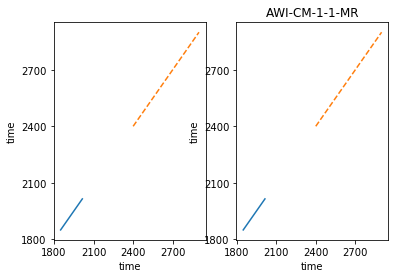

noleap
noleap


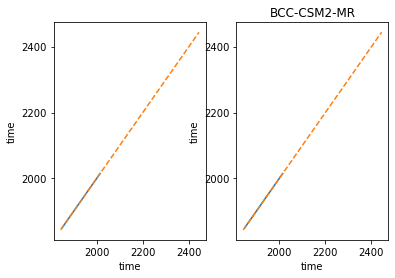

noleap
noleap


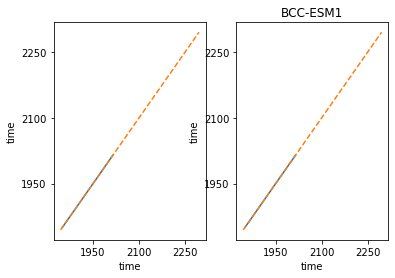

noleap
noleap


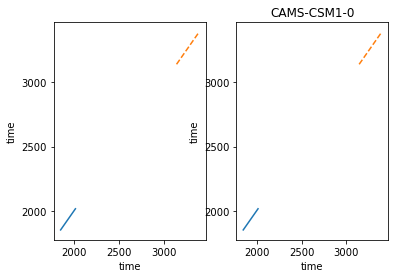

noleap
noleap


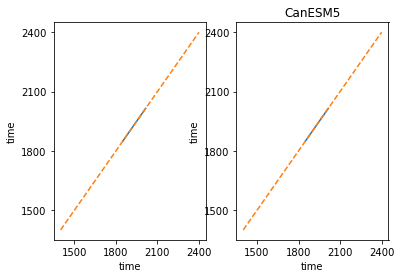

gregorian
gregorian


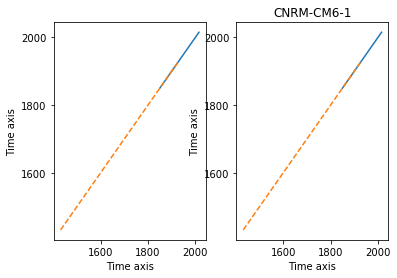

gregorian
gregorian


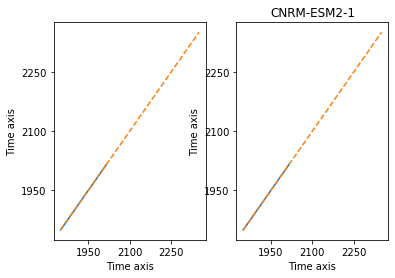

proleptic_gregorian
proleptic_gregorian


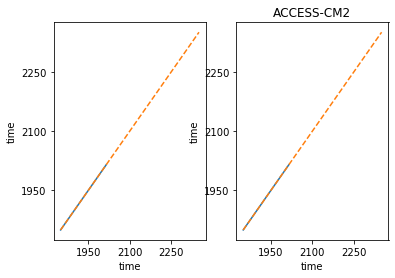

proleptic_gregorian
proleptic_gregorian


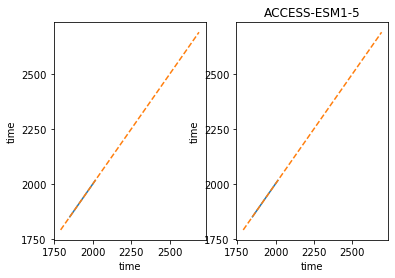

noleap
noleap


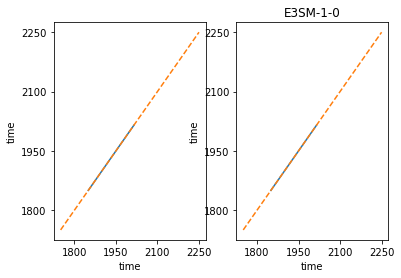

noleap
noleap


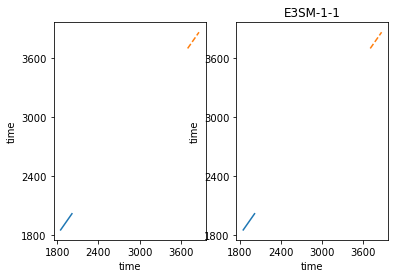

proleptic_gregorian
proleptic_gregorian


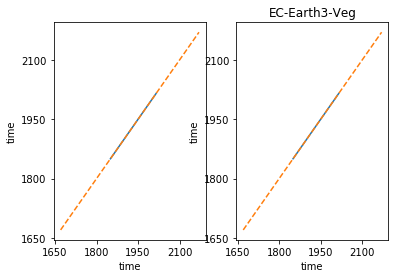

gregorian
proleptic_gregorian


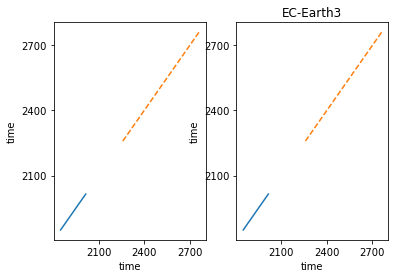

noleap
noleap


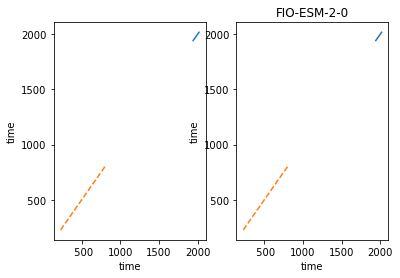

noleap
noleap


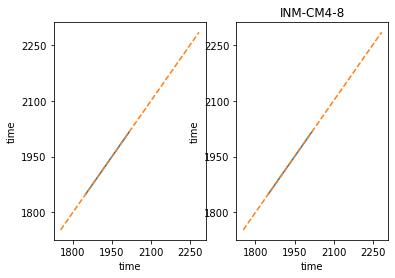

gregorian
gregorian


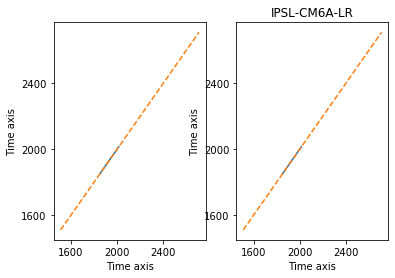

gregorian
gregorian


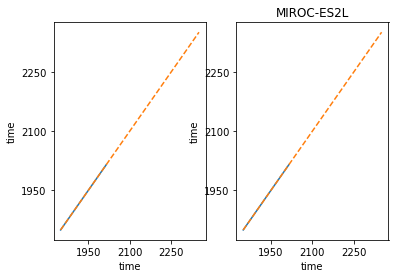

gregorian
gregorian


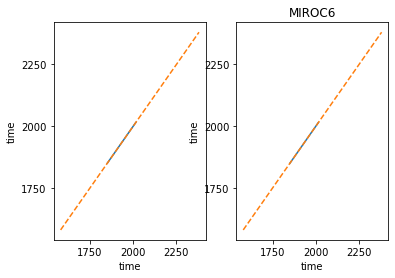

360_day
360_day


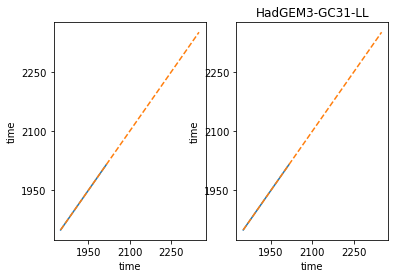

360_day
360_day


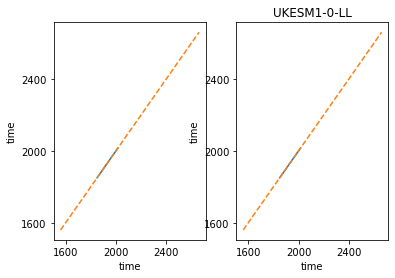

proleptic_gregorian
proleptic_gregorian


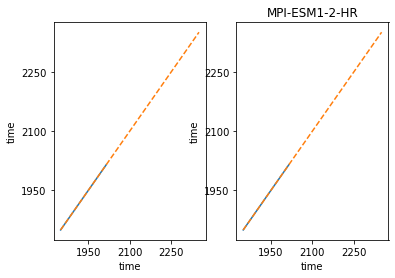

proleptic_gregorian
proleptic_gregorian


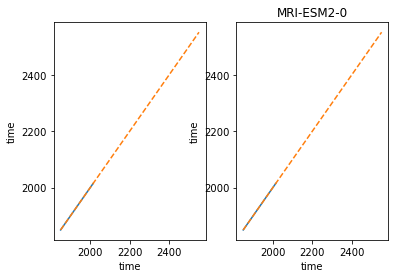

noleap
noleap


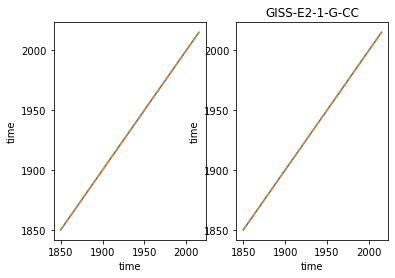

noleap
noleap


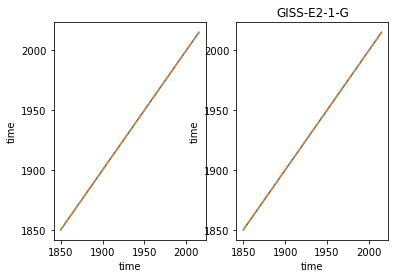

noleap
noleap


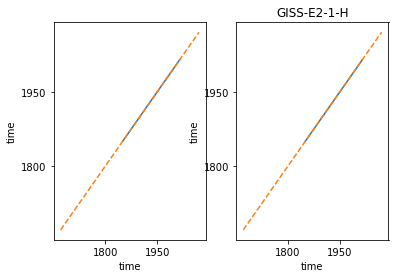

noleap
noleap


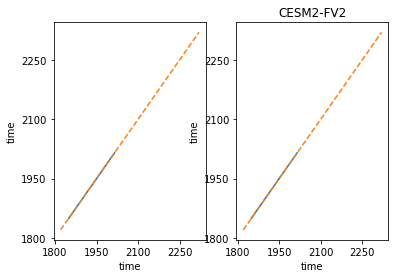

noleap
noleap


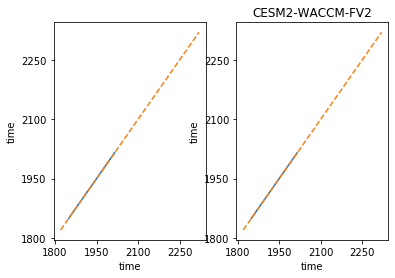

noleap
noleap


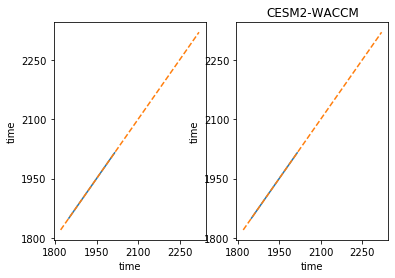

noleap
noleap


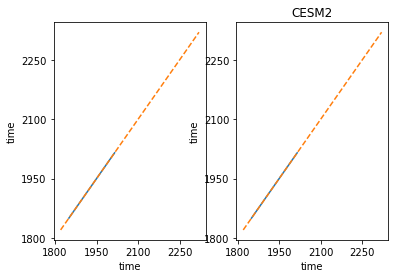

noleap
noleap


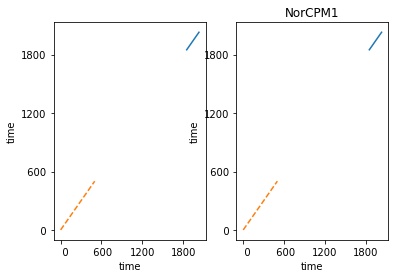

noleap
noleap


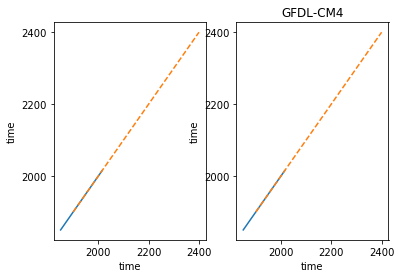

noleap
noleap


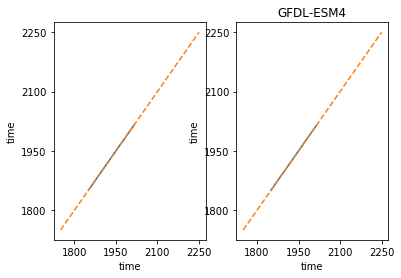

noleap
noleap


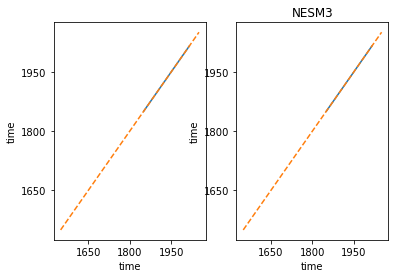

noleap
noleap


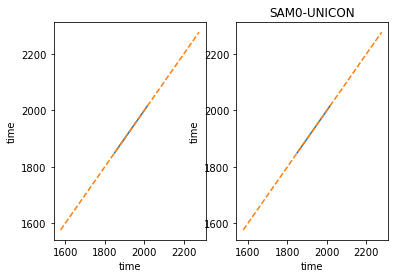

noleap
noleap


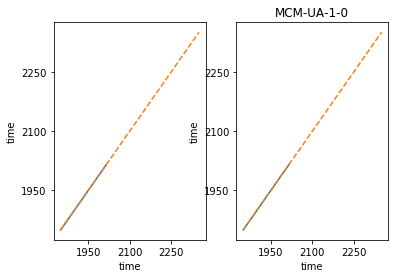

In [315]:
from cmip6_preprocessing.time_utils import _decode_wrapper
for model in full_models:

    hist = data_dict_timefixed[[k for k in data_dict_timefixed.keys() if (model in k) & ('historical' in k)][0]]
    cont = data_dict_timefixed[[k for k in data_dict_timefixed.keys() if (model in k) & ('piControl' in k)][0]]

    hist_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('historical' in k)][0]]
    cont_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('piControl' in k)][0]]
    
    print(hist.time.data[0].calendar)
    print(cont.time.data[0].calendar)
    
    for k in [kk for kk in hist_raw.attrs.keys() if 'branch' in kk]:
        pass

    plt.figure()

    try:
        
        plt.subplot(1,2,1)
        hist_raw.time.plot()
        cont_raw.time.plot(ls='--')
        
        
    except:
        pass
    try:
        plt.subplot(1,2,2)
        hist.time.plot()
        cont.time.plot(ls='--')
        plt.title(model)
        plt.show() 
       
    except:
        print(f"{model} fucked up")
    
   

In [187]:
# canesm has negative time for the control run?

In [83]:
hist_raw.time[0].data

array(cftime.DatetimeProlepticGregorian(1850-01-16 12:00:00), dtype=object)

In [84]:
branch_time_adjusted

cftime.DatetimeProlepticGregorian(1850-01-16 12:00:00)